# Explore here

In [83]:
# importar librerias
import pandas as pd
import numpy as np
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [84]:
#cargar dataset
url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
df = pd.read_csv(url)
df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [85]:
#convertir columna is_spam a tipo de dato numerico
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x == True else 0)
df['is_spam'].value_counts()

is_spam
0    2303
1     696
Name: count, dtype: int64

In [86]:
#eliminar filas duplicadas
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.shape

(2369, 2)

- Mas de 600 filas duplicadas eliminadas

In [87]:
#preprocesamiento de texto
def preprocess_text(text):
    #quitar caracteres que no sean letras de a-z o espacios
    text = re.sub(r'[^a-z ]', " ", text)

    # quitar espacios
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # convertir espacios blanco seguidos en uno y convertir en minusculas
    text = re.sub(r'\s+', " ", text.lower())

    # quitar etiquetas de HTML/XML
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

df['url'] = df['url'].apply(preprocess_text)
df

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2364,"[https, www, theverge, com, disney, deepfake, ...",0
2365,"[https, www, smartcitiesworld, net, news, news...",0
2366,"[https, techcrunch, com, an, optimistic, view,...",0
2367,"[https, www, technologyreview, com, this, star...",0


In [88]:
#lemmatizacion del texto
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df["url"] = df["url"].apply(lemmatize_text)
df

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1
...,...,...
2364,"[http, theverge, disney, deepfake, face, swapp...",0
2365,"[http, smartcitiesworld, news, news, deepfake,...",0
2366,"[http, techcrunch, optimistic, view, deepfakes]",0
2367,"[http, technologyreview, startup, claim, deepf...",0


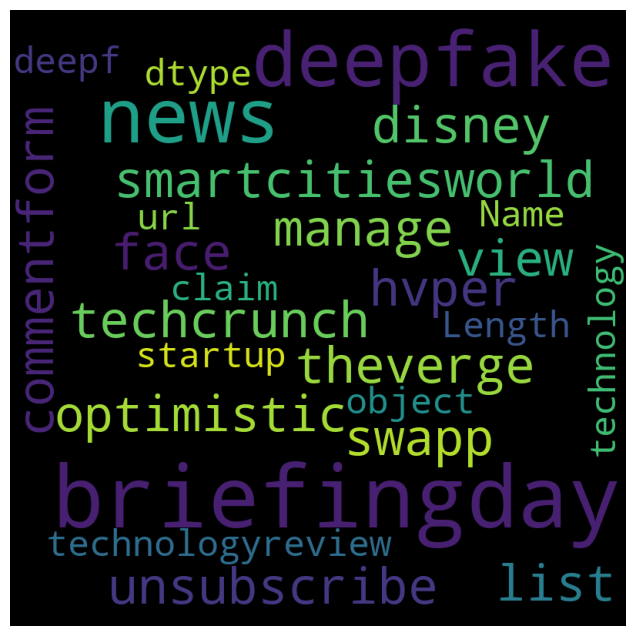

In [89]:
#wordcloud
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [90]:
#crear token con lista de listas
tokens_list = df['url']
tokens_list = [" ".join(token) for token in tokens_list]

#vectorizacion de texto
vectorizer = TfidfVectorizer(max_features=5000, max_df = 0.8, min_df=5)

#definir X e y
X = vectorizer.fit_transform(tokens_list).toarray()
y = df['is_spam']

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2369, 538))

In [91]:
#separar en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [92]:
#crear modelo svm
model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [93]:
#obtener predicciones
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [94]:
#ver reporte de clasificacion
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       435
           1       0.83      0.51      0.63        39

    accuracy                           0.95       474
   macro avg       0.90      0.75      0.80       474
weighted avg       0.95      0.95      0.95       474



In [ ]:
#optimizacion del modelo en f1
def grid_SVM(X_train, y_train, performance_metric='f1', resultsGrid=False):
    model = SVC(random_state=666)
    C = np.linspace(0.1 , 50, 250)
    kernels = ['poly', 'rbf','sigmoid', 'linear' ]
    gamma = ['scale', 'auto']
    grid = dict(C = C, kernel = kernels, gamma = gamma)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                           scoring=performance_metric,error_score='raise')
    grid_result = grid_search.fit(X_train, y_train)
    if resultsGrid==True:
        return grid_result.cv_results_
    else:
        return  grid_result.best_estimator_
    
best_model = grid_SVM(X_train, y_train, performance_metric='f1', resultsGrid=False)

In [96]:
#predecir con mejor modelo
y_pred = best_model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [ ]:
#ver reporte de clasificacion de funcion optimizada
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       435
           1       0.80      0.72      0.76        39

    accuracy                           0.96       474
   macro avg       0.89      0.85      0.87       474
weighted avg       0.96      0.96      0.96       474

